# Вторая часть проекта. Разработка модели

## 2. Выбор архитектуры модели. Тестирование для разных n

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from dataclasses import dataclass
from tqdm import tqdm
from itertools import product

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from graphs import KNN_Graph, Distance_Graph
from characteristics_applied import *
from visualisations import *
from metrics import *
from classifier import *

### Базовая модель (рюкзак с контролем ошибки I рода)

In [2]:
def describe_model_quality(y_pred, y_test, title, info):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"-------------------{title}-------------------")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC: {roc_auc}')

    if info['prediction_type'] == 'A_indicator':
        model = info['model']
        exp_points = info['exp_points']
        pareto_points = info['pareto_points']

        I_error = calc_I_error_clfr(model, exp_points)
        power = calc_power_clfr(model, pareto_points)

        print(f'Ошибка первого рода = {I_error}')
        print(f'Мощность = {power}')

In [3]:
def fit_rucksack_model(n, observations_count=500):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr_validator = DistibutionClassifier(n=n, observations_count=observations_count // 2)

    clfr.generate_important_chars_points()
    clfr_validator.generate_important_chars_points()

    clfr.fit(clfr_validator.exp_points, clfr_validator.pareto_points, verbose=True)

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = clfr.predict_items(X_test)
    describe_model_quality(y_pred, y_test, "Rucksack model metrics", {
        'prediction_type' : 'A_set',
        'A_set' : clfr.A,
        'tester' : clfr_tester
    })

Generating characteristics...


100%|██████████| 1200/1200 [00:06<00:00, 176.34it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 600/600 [00:02<00:00, 219.07it/s]



Characteristics generated!
Building A...


 92%|█████████▏| 300/327 [25:52<02:19,  5.17s/it]


A builded with power = 0.9416666666666667, I_error = 0.04833333333333333!


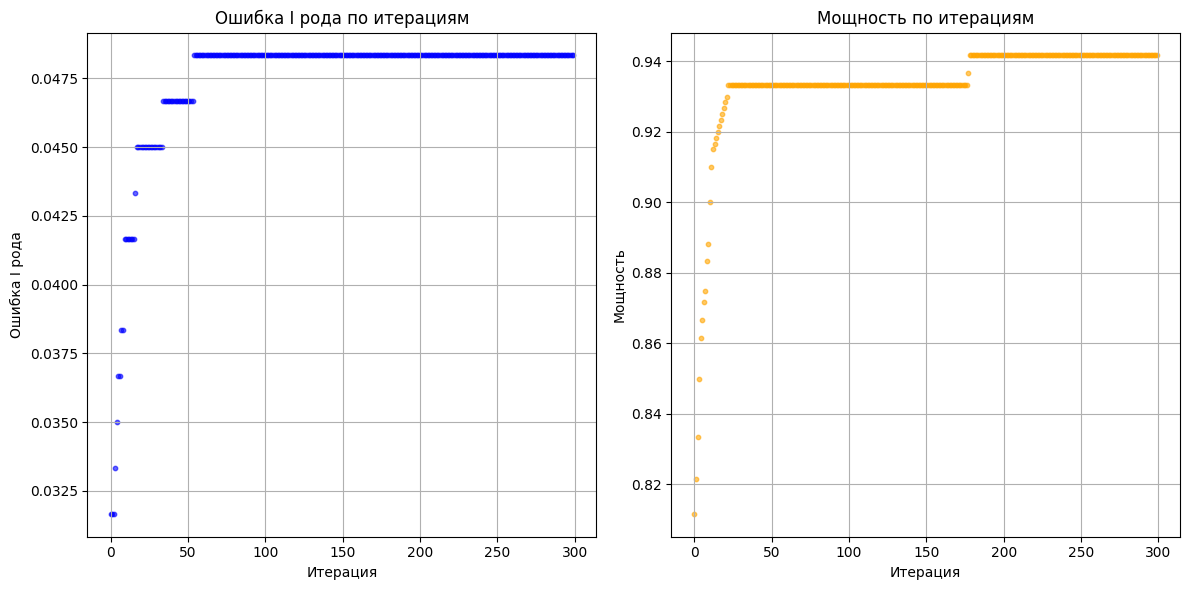

Generating characteristics...


100%|██████████| 200/200 [00:01<00:00, 186.59it/s]


Characteristics generated!
-------------------Rucksack model metrics-------------------
Accuracy: 0.9375
Precision: 0.9396984924623115
Recall: 0.935
F1 Score: 0.9373433583959899
ROC AUC: 0.9375


In [7]:
fit_rucksack_model(n=75, observations_count=1200)

### Случайный лес

In [10]:
def pick_random_forest_model(X_train, y_train):
    n_estimators_variants = [5, 10, 50, 100]
    max_depth_variants = [None, 5, 10, 20, 40, 80, 160]
    min_samples_leaf_variants = [1, 2, 5, 10, 20]

    param_grid = {
        'n_estimators' : n_estimators_variants,
        'max_depth': max_depth_variants,
        'min_samples_leaf': min_samples_leaf_variants
    }
    model_random_forest = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid,
                            scoring='f1', cv=5, n_jobs=-1)

    grid_search.fit(X_train, y_train.to_numpy().flatten().ravel())
    return grid_search.best_estimator_

def fit_random_forest_model(n, observations_count=300):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr.generate_important_chars_points()

    X_train, y_train = clfr.get_points_dataset()

    model = pick_random_forest_model(X_train, y_train)

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = model.predict(X_test)
    describe_model_quality(y_pred, y_test, f"Random forest model metrics (n = {n})", {
        'prediction_type' : 'A_indicator',
        'model' : model,
        'exp_points' : clfr_tester.exp_points,
        'pareto_points' : clfr_tester.pareto_points
    })

In [11]:
fit_random_forest_model(50, 700)

Generating characteristics...


100%|██████████| 700/700 [00:02<00:00, 336.97it/s]


Characteristics generated!


Generating characteristics...


100%|██████████| 200/200 [00:01<00:00, 196.84it/s]



Characteristics generated!
-------------------Random forest model metrics (n = 50)-------------------
Accuracy: 0.875
Precision: 0.8865979381443299
Recall: 0.86
F1 Score: 0.8730964467005076
ROC AUC: 0.875
Ошибка первого рода = 0.11
Мощность = 0.86


In [12]:
fit_random_forest_model(100, 1000)

Generating characteristics...


100%|██████████| 1000/1000 [00:07<00:00, 141.78it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:01<00:00, 144.56it/s]


Characteristics generated!
-------------------Random forest model metrics (n = 100)-------------------
Accuracy: 0.985
Precision: 0.9801980198019802
Recall: 0.99
F1 Score: 0.9850746268656716
ROC AUC: 0.985
Ошибка первого рода = 0.02
Мощность = 0.99


In [13]:
fit_random_forest_model(500, 1500)

Generating characteristics...


100%|██████████| 1500/1500 [03:02<00:00,  8.21it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


Characteristics generated!
-------------------Random forest model metrics (n = 500)-------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Ошибка первого рода = 0.0
Мощность = 1.0


### Логистическая регрессия

In [14]:
def fit_logistic_regression_model(n, observations_count=1000):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr.generate_important_chars_points()
    X_train, y_train = clfr.get_points_dataset()

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])
    model.fit(X_train, y_train.to_numpy().flatten().ravel())

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = model.predict(X_test)
    describe_model_quality(y_pred, y_test, f"Logistic regression model metrics (n = {n})", {
        'prediction_type' : 'A_indicator',
        'model' : model,
        'exp_points' : clfr_tester.exp_points,
        'pareto_points' : clfr_tester.pareto_points
    })

In [15]:
fit_logistic_regression_model(50, 700)

Generating characteristics...


100%|██████████| 700/700 [00:02<00:00, 336.97it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:00<00:00, 314.64it/s]


Characteristics generated!
-------------------Logistic regression model metrics (n = 50)-------------------
Accuracy: 0.8575
Precision: 0.8864864864864865
Recall: 0.82
F1 Score: 0.8519480519480519
ROC AUC: 0.8574999999999999
Ошибка первого рода = 0.105
Мощность = 0.82


In [16]:
fit_logistic_regression_model(100, 500)

Generating characteristics...


100%|██████████| 500/500 [00:03<00:00, 146.11it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:01<00:00, 139.04it/s]



Characteristics generated!
-------------------Logistic regression model metrics (n = 100)-------------------
Accuracy: 0.985
Precision: 0.98989898989899
Recall: 0.98
F1 Score: 0.9849246231155779
ROC AUC: 0.985
Ошибка первого рода = 0.01
Мощность = 0.98


In [17]:
fit_logistic_regression_model(500, 1500)

Generating characteristics...


100%|██████████| 1500/1500 [03:02<00:00,  8.21it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


Characteristics generated!
-------------------Logistic regression model metrics (n = 500)-------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Ошибка первого рода = 0.0
Мощность = 1.0
